In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
import optuna
from optuna.samplers import TPESampler
import joblib
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
import os
from zipfile import ZipFile
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
os.chdir(r'C:\Users\jason\OneDrive\桌面\Northeastern University\course\quarter 5\EAI 6020\W3\Assignment')

## Data Preprocessing

In [3]:
# Dataset owner and name (extracted from the URL)
dataset_owner = "uciml"
dataset_name = "red-wine-quality-cortez-et-al-2009"

# Use the Kaggle API to download the dataset
os.system(f'kaggle datasets download -d {dataset_owner}/{dataset_name}')

# Unzip the downloaded file
with ZipFile(f'{dataset_name}.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('winequality-red.csv')

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.shape

(1599, 12)

In [7]:
# Detect missing value
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

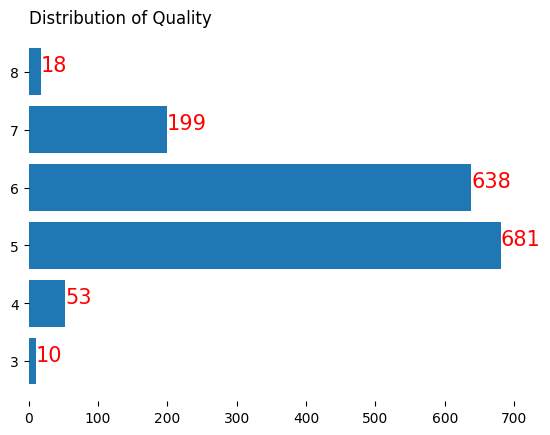

In [8]:
# Exploratory data analysis
plt.barh(df.loc[:,'quality'].sort_values().value_counts().index, df.loc[:,'quality'].sort_values().value_counts())
for i, counts in df.loc[:,'quality'].sort_values().value_counts().items():
    plt.text(counts, i, f'{counts}', color='red', fontsize=15)
plt.title('Distribution of Quality', loc='left')
ax = plt.gca()
ax.set_frame_on(False)

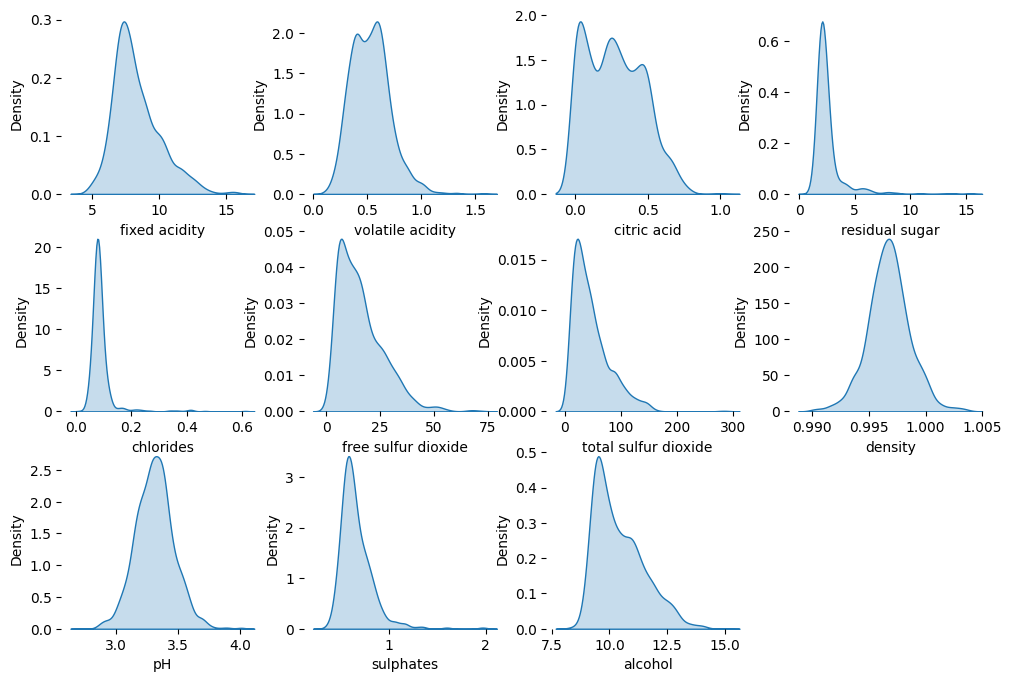

In [9]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns):
    if i+1 == df.shape[1]:
        break
    plt.subplot(3, 4, i+1)
    sns.kdeplot(df.loc[:,column], fill=True)
    ax = plt.gca()
    ax.set_frame_on(False)


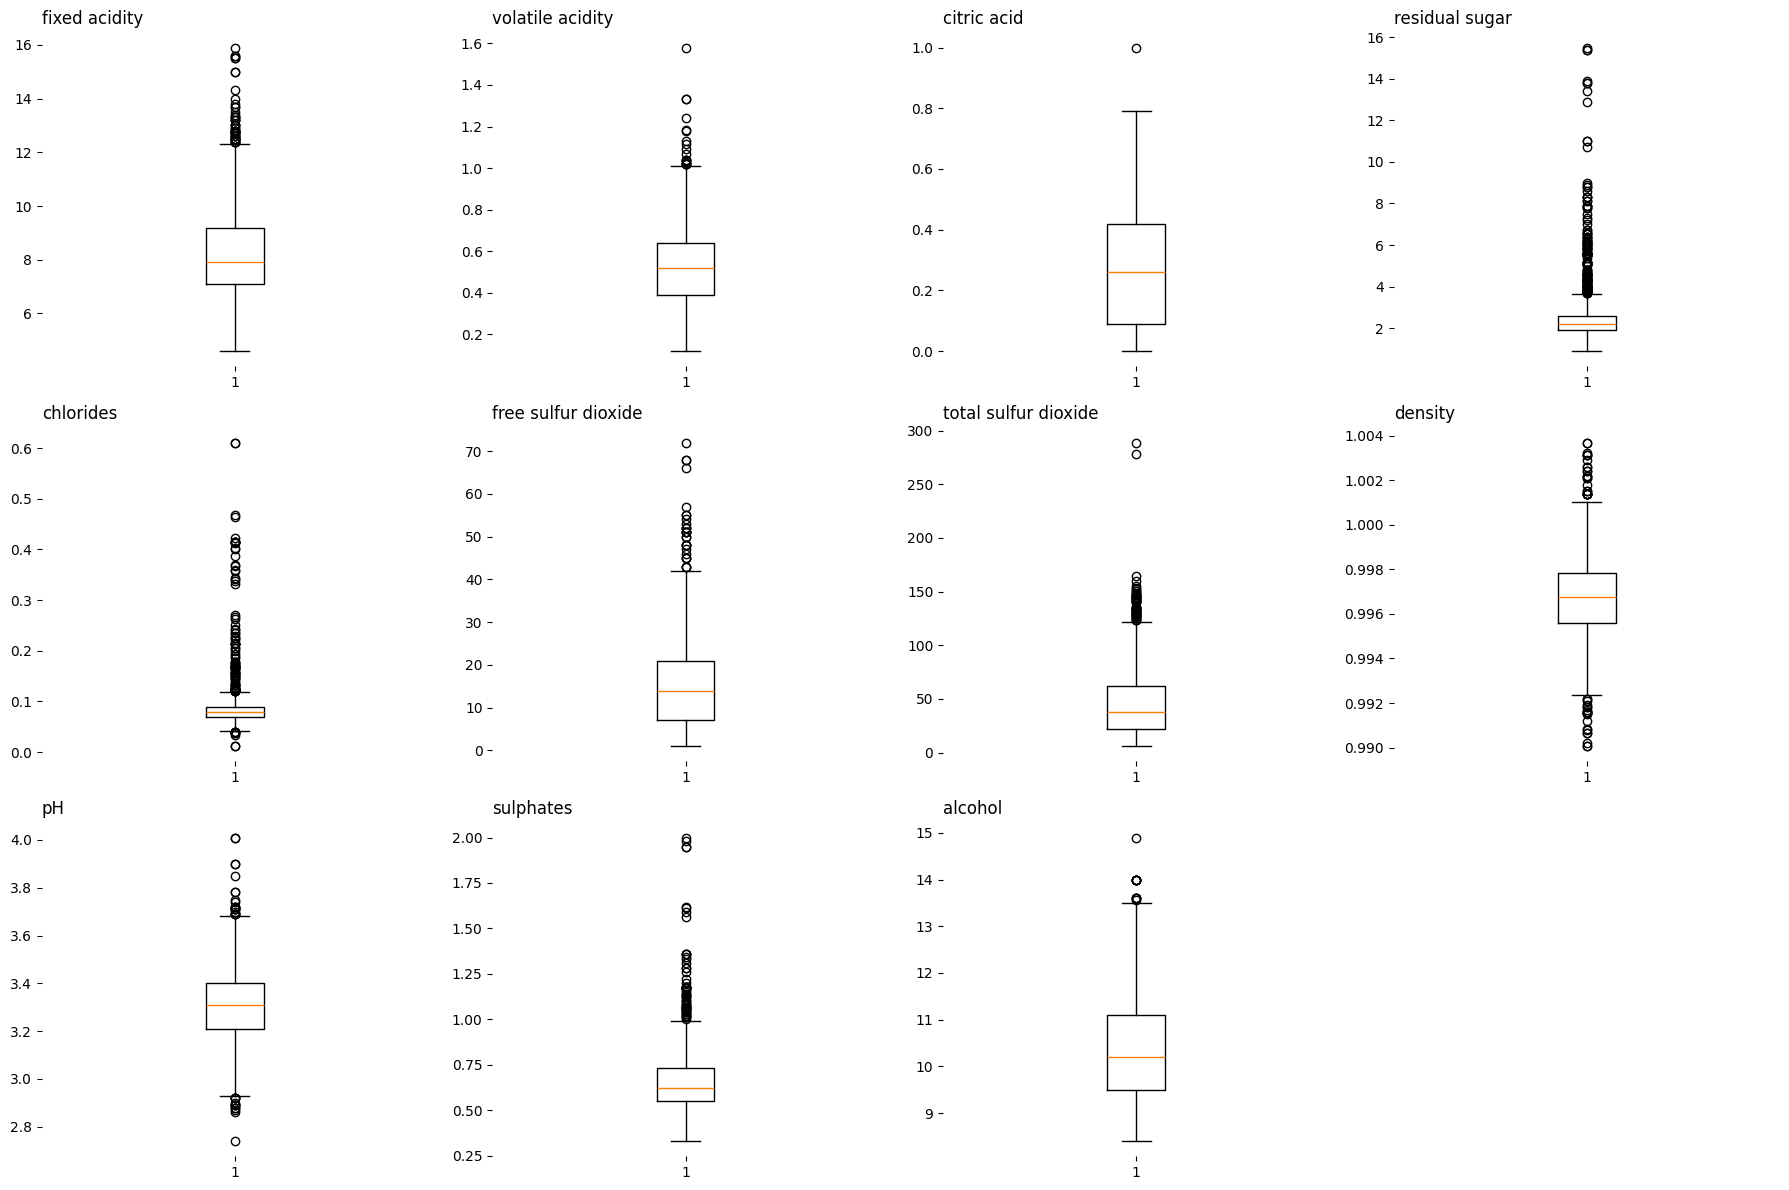

In [10]:
plt.figure(figsize=(18, 12))
for i, column in enumerate(df.columns):
    if i+1 == df.shape[1]:
        break
    plt.subplot(3, 4, i+1)
    plt.boxplot(df.loc[:,column])
    plt.title(column, loc='left')
    plt.tight_layout()
    ax = plt.gca()
    ax.set_frame_on(False)

In [11]:
df_independent = df.drop('quality', axis=1)
df_dependent = df.loc[:,'quality']

In [12]:
df_independent.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [13]:
sc = StandardScaler()

In [14]:
df_independent_sc = sc.fit_transform(df_independent)

In [15]:
X = pd.DataFrame(df_independent_sc, columns=df_independent.columns)

In [16]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


In [17]:
y = df.loc[:,'quality']

In [18]:
# Split the dataset
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: get the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(df_independent, df_dependent, test_size=test_size, random_state=42)

# Second split: divide the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=42)

In [19]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [20]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1119, 11)
(240, 11)
(240, 11)


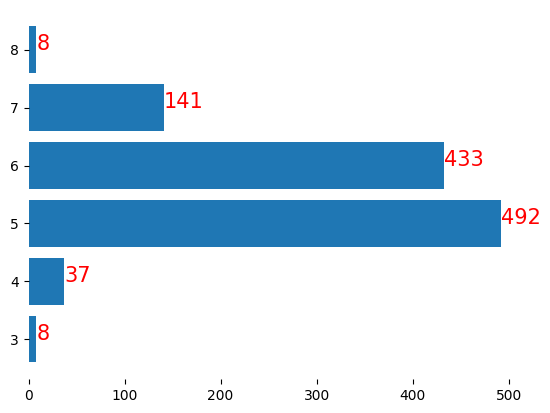

In [21]:
plt.barh(y_train.sort_values().value_counts().index, y_train.sort_values().value_counts())
for i, counts in y_train.sort_values().value_counts().items():
    plt.text(counts, i, f'{counts}', color='red', fontsize=15)
    ax = plt.gca()
    ax.set_frame_on(False)

In [22]:
# Oversampling
smote = SMOTE(random_state=42)

In [23]:
X_train, y_train = smote.fit_resample(X_train, y_train)

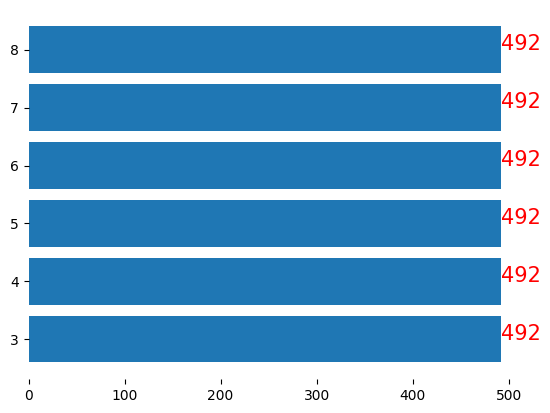

In [24]:
plt.barh(y_train.sort_values().value_counts().index, y_train.sort_values().value_counts())
for i, counts in y_train.sort_values().value_counts().items():
    plt.text(counts, i, f'{counts}', color='red', fontsize=15)
    ax = plt.gca()
    ax.set_frame_on(False)

## Model Building - Random Forest

In [25]:
# Define an objective function for hyperparameter optimization
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200, step=50)  # number of trees in a forest
    max_depth = trial.suggest_categorical('max_depth', list(range(3, 11)) + [None])  # Maximum depth of the tree, range from 3 to 10 and "None"
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples required to split a node, range from 2 to 10
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)  # Minimum samples in a leaf node, range from 1 to 4
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Initialize the model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    y_pred = rf_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    # Return f1_score as the result of the objective function
    return accuracy

sampler = TPESampler(seed=42)

# Initialize Optuna study object
study = optuna.create_study(direction='maximize', sampler=sampler)  # Set the objective to maximize accuracy score

# Perform hyperparameter optimization
study.optimize(objective, n_trials=50)  # Set to optimize for several trials

# Display the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters found: ", study.best_params)
print("Best f1 score: ", study.best_value)

[I 2025-03-14 01:08:56,704] A new study created in memory with name: no-name-9df5e044-337c-4e8e-9fa1-be013683a9fc
[I 2025-03-14 01:08:57,312] Trial 0 finished with value: 0.30833333333333335 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.30833333333333335.
[I 2025-03-14 01:08:57,563] Trial 1 finished with value: 0.5291666666666667 and parameters: {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5291666666666667.
[I 2025-03-14 01:08:58,237] Trial 2 finished with value: 0.49583333333333335 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5291666666666667.
[I 2025-03-14 01:09:01,664] Trial 3 finished with value: 0.49166666666666664 and parameters: {'n_estimators': 150, 'max_depth': 7, 'mi

Best hyperparameters found:  {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best f1 score:  0.6833333333333333


In [26]:
best_params = study.best_params

In [27]:
print('Parameter selection for the random forest model:')
print('Number of estimators:', best_params['n_estimators'])
print('Max depth:', best_params['max_depth'])
print('Min samples split:', best_params['min_samples_split'])
print('Min samples leaf:', best_params['min_samples_leaf']) 
print('Max features:', best_params['max_features'])

Parameter selection for the random forest model:
Number of estimators: 200
Max depth: None
Min samples split: 5
Min samples leaf: 1
Max features: sqrt


In [28]:
rf_new_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], 
                                  min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'], random_state=42)

## Model Evaluation

In [29]:
rf_new_model.fit(X_train, y_train)
y_pred = rf_new_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nModel Accuracy: {accuracy:.2f}")
print(f"\nModel F1 Score: {f1:.2f}")


Model Accuracy: 0.62

Model F1 Score: 0.63


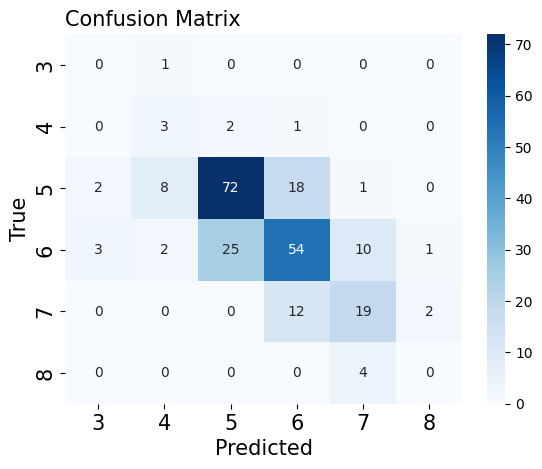

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix', loc='left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
joblib.dump(rf_new_model, 'rf_model.joblib')

['rf_model.joblib']

## Model Building - K Nearest Neighbor

In [32]:
# Split the dataset
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: get the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Second split: divide the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=42)

In [33]:
# KNN model
# PCA to reduce dimensions
pca = PCA()

In [34]:
X_pca = pca.fit_transform(X)

In [35]:
# Store explained variance for each component in a variable
exp_var_pca = pca.explained_variance_ratio_

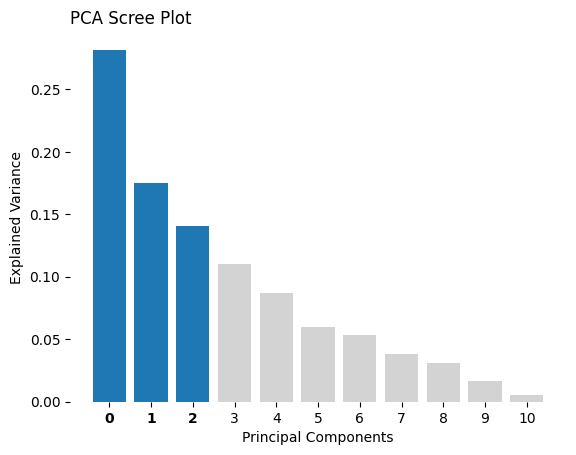

In [36]:
bar_color = ['#1f77b4']*3 + ['lightgrey']*8

# Visualise the components versus their explained variance
plt.title('PCA Scree Plot', loc='left')
plt.bar(range(0,len(exp_var_pca)),exp_var_pca, color=bar_color)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.xticks(range(X.shape[1]))

xticklabels = plt.gca().get_xticklabels()
for idx, label in enumerate(xticklabels):
    if idx <= 2:
        label.set_fontweight('bold')

ax = plt.gca() ## Remove the border to reduce cognitive load
ax.set_frame_on(False) ## Remove the border to reduce cognitive load

In [37]:
# Perform a new PCA with components equal "3"
pca_update = PCA(n_components=3)

In [38]:
# Store the results in a new variable
result = pca_update.fit_transform(X)

In [39]:
df_KNN = pd.DataFrame(result)
df_KNN

,0,1,2
0,-1.619530,0.450950,-1.774454
1,-0.799170,1.856553,-0.911690
2,-0.748479,0.882039,-1.171394
3,2.357673,-0.269976,0.243489
4,-1.619530,0.450950,-1.774454
...,...,...,...
1594,-2.150500,0.814286,0.617063
1595,-2.214496,0.893101,1.807402
1596,-1.456129,0.311746,1.124239
1597,-2.270518,0.979791,0.627965


In [40]:
# Split the dataset
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: get the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(df_KNN, y, test_size=test_size, random_state=42)

# Second split: divide the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=42)

In [41]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [42]:
#Determine the hyperparameter in KNN algorithms: K
Ks=50
accuracy=np.zeros((Ks-1))


# Train and predict
for n in range(1,Ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat=neigh.predict(X_val)
    accuracy[n-1]=accuracy_score(y_val,yhat)

In [43]:
# Observe the best accuracy with the optimal number of K
print( "The best accuracy was", accuracy.max(), "with k=", accuracy.argmax()+1) 

The best accuracy was 0.6041666666666666 with k= 28


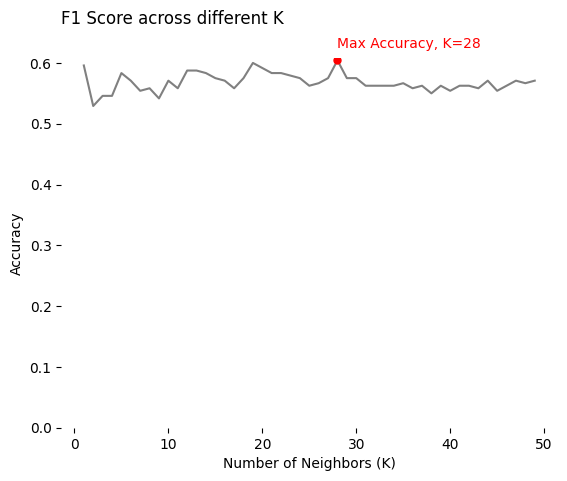

In [44]:
# Visualise the accuracy over iterations
plt.plot(range(1,Ks),accuracy, color='grey')
plt.title('F1 Score across different K', loc='left', y=1.07)
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.plot(accuracy.argmax()+1, accuracy.max(), marker='o', color='red', markersize=5)
plt.yticks(np.arange(0, np.max(accuracy), 0.1))
plt.text(accuracy.argmax()+1, accuracy.max()+0.02, f'Max Accuracy, K={accuracy.argmax()+1}', color='red')
ax = plt.gca()
ax.set_frame_on(False)
plt.show()

In [45]:
KNN_new_model = KNeighborsClassifier(n_neighbors=1)

## Model Evaluation

In [46]:
KNN_new_model.fit(X_train, y_train)
y_pred = KNN_new_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nModel Accuracy: {accuracy:.2f}")
print(f"\nModel F1 Score: {f1:.2f}")


Model Accuracy: 0.61

Model F1 Score: 0.60


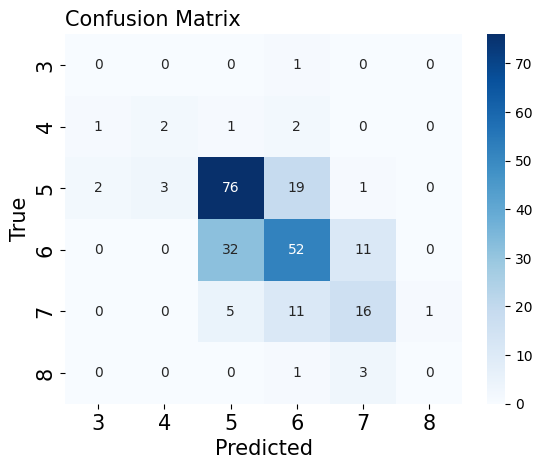

In [47]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix', loc='left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Model Building - Neural Network (with a Larger Learning Rate)

In [48]:
# Transform the dependent feature so that the neural network can use them
df_dependent = df_dependent - 3

In [49]:
# Split the dataset
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: get the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(df_independent, df_dependent, test_size=test_size, random_state=42)

# Second split: divide the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=42)

In [50]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [51]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1119, 11)
(240, 11)
(240, 11)


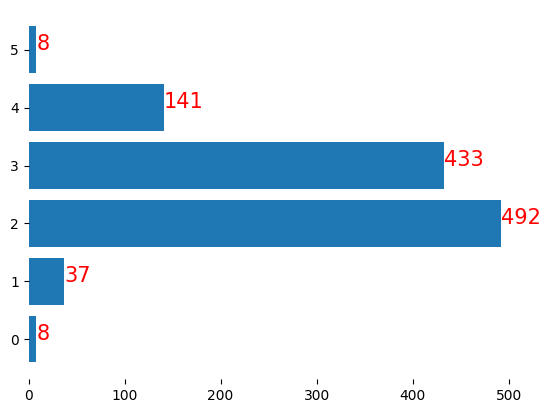

In [52]:
plt.barh(y_train.sort_values().value_counts().index, y_train.sort_values().value_counts())
for i, counts in y_train.sort_values().value_counts().items():
    plt.text(counts, i, f'{counts}', color='red', fontsize=15)
ax = plt.gca()
ax.set_frame_on(False)

In [53]:
# Oversampling
smote = SMOTE(random_state=42)

In [54]:
X_train, y_train = smote.fit_resample(X_train, y_train)

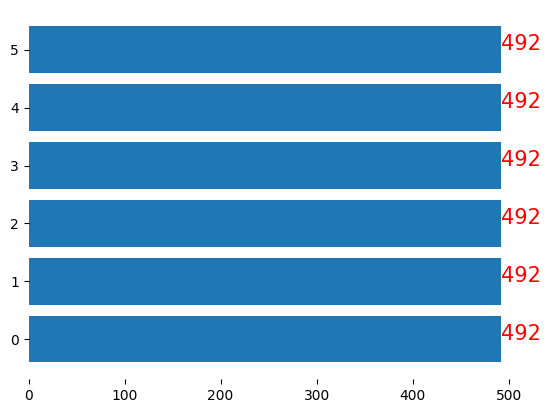

In [55]:
plt.barh(y_train.sort_values().value_counts().index, y_train.sort_values().value_counts())
for i, counts in y_train.sort_values().value_counts().items():
    plt.text(counts, i, f'{counts}', color='red', fontsize=15)
ax = plt.gca()
ax.set_frame_on(False)

In [56]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.ln1 = nn.LayerNorm(200)

        self.fc2 = nn.Linear(200, 175)
        self.ln2 = nn.LayerNorm(175)

        self.fc3 = nn.Linear(175, 150)
        self.ln3 = nn.LayerNorm(150)

        self.fc4 = nn.Linear(150, 125)
        self.ln4 = nn.LayerNorm(125)

        self.fc5 = nn.Linear(125, 100)
        self.ln5 = nn.LayerNorm(100)

        self.fc6 = nn.Linear(100, 75)
        self.ln6 = nn.LayerNorm(75)

        self.fc7 = nn.Linear(75, 50)
        self.ln7 = nn.LayerNorm(50)

        self.fc8 = nn.Linear(50, 25)
        self.ln8 = nn.LayerNorm(25)

        self.fc9 = nn.Linear(25, len(np.unique(df.loc[:,'quality'])))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.ln1(self.fc1(x)))
        x = self.relu(self.ln2(self.fc2(x)))
        x = self.relu(self.ln3(self.fc3(x)))
        x = self.relu(self.ln4(self.fc4(x)))
        x = self.relu(self.ln5(self.fc5(x)))
        x = self.relu(self.ln6(self.fc6(x)))
        x = self.relu(self.ln7(self.fc7(x)))
        x = self.relu(self.ln8(self.fc8(x)))
        x = self.fc9(x) 
        return x

In [57]:
nn_model = NN()

In [58]:
loss_fn = nn.CrossEntropyLoss()

In [59]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_valid_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [60]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=X_train_tensor.shape[0], shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=X_valid_tensor.shape[0], shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=X_test_tensor.shape[0], shuffle=False)

In [61]:
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.001)

In [62]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [63]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = nn_model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()

    last_loss = running_loss/ (i+1)
            
    return last_loss

In [64]:
EPOCHS = 1000

avg_loss_list = []
avg_vloss_list = []
acc_list = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    nn_model.train()
    avg_loss = train_one_epoch(epoch_number, writer)
    
    nn_model.eval()
    running_vloss = 0.0
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        voutputs = nn_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / len(valid_loader)
    print('LOSS: training {} validation {}'.format(avg_loss, avg_vloss))
    
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    avg_loss_list.append(avg_loss)
    avg_vloss_list.append(avg_vloss)

    epoch_number += 1

EPOCH 1:
LOSS: training 1.8854345083236694 validation 2.038745403289795
EPOCH 2:
LOSS: training 1.8751659393310547 validation 2.0125341415405273
EPOCH 3:
LOSS: training 1.8660837411880493 validation 1.9899349212646484
EPOCH 4:
LOSS: training 1.8584680557250977 validation 1.9702669382095337
EPOCH 5:
LOSS: training 1.851963758468628 validation 1.95273756980896
EPOCH 6:
LOSS: training 1.8463331460952759 validation 1.9369301795959473
EPOCH 7:
LOSS: training 1.841334342956543 validation 1.9224995374679565
EPOCH 8:
LOSS: training 1.8368971347808838 validation 1.9096086025238037
EPOCH 9:
LOSS: training 1.832983136177063 validation 1.898188829421997
EPOCH 10:
LOSS: training 1.8295000791549683 validation 1.8878026008605957
EPOCH 11:
LOSS: training 1.8263081312179565 validation 1.8781917095184326
EPOCH 12:
LOSS: training 1.8233091831207275 validation 1.8693636655807495
EPOCH 13:
LOSS: training 1.8204692602157593 validation 1.8614563941955566
EPOCH 14:
LOSS: training 1.817784309387207 validation 

In [65]:
numpy_array_list = [tensor.detach().numpy() for tensor in avg_vloss_list]

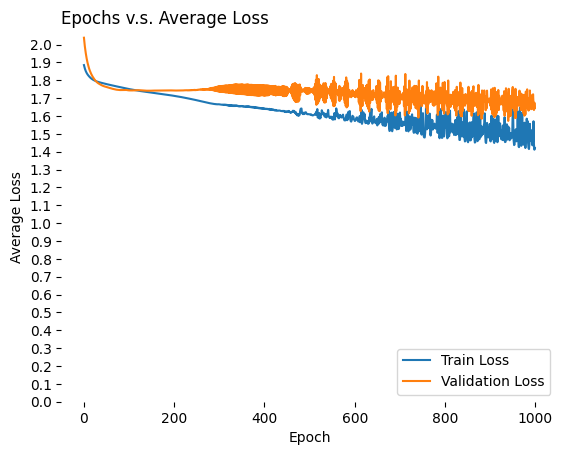

In [66]:
max_value = max(np.max(avg_loss_list), np.max(numpy_array_list))

plt.plot(avg_loss_list)
plt.plot(numpy_array_list)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yticks(np.arange(0, max_value, 0.1))
plt.title('Epochs v.s. Average Loss', loc='left')
plt.legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax = plt.gca()
ax.set_frame_on(False)

## Model Evaluation

In [67]:
nn_model.eval()

predicted_classes = []
actual_labels = []


with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        toutputs = nn_model(tinputs)
        
        _, predicted = torch.max(toutputs, 1)
        
        predicted_classes.extend(predicted.cpu().numpy())
        actual_labels.extend(tlabels.cpu().numpy())

print("Predicted Classes: ", predicted_classes)
print("Actual Labels: ", actual_labels)

Predicted Classes:  [np.int64(3), np.int64(2), np.int64(4), np.int64(0), np.int64(4), np.int64(3), np.int64(2), np.int64(4), np.int64(3), np.int64(3), np.int64(5), np.int64(1), np.int64(4), np.int64(0), np.int64(3), np.int64(4), np.int64(2), np.int64(2), np.int64(5), np.int64(2), np.int64(1), np.int64(3), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(5), np.int64(2), np.int64(2), np.int64(5), np.int64(2), np.int64(5), np.int64(5), np.int64(5), np.int64(4), np.int64(2), np.int64(4), np.int64(1), np.int64(5), np.int64(4), np.int64(5), np.int64(2), np.int64(5), np.int64(2), np.int64(5), np.int64(4), np.int64(5), np.int64(5), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(5), np.int64(4), np.int64(4), np.int64(3), np.int64(5), np.int64(3), np.int64(2), np.int64(4), np.int64(3), np.int64(5), np.int64(2), np.int64(3), np.int64(2), np.int64(5), np.int64(2), np.int64(5), np.int64(4), np.int64(4), np.i

In [68]:
accuracy = accuracy_score(actual_labels,predicted_classes)
f1 = f1_score(actual_labels,predicted_classes, average='weighted')
print(f"\nModel Accuracy: {accuracy:.2f}")
print(f"\nModel F1 Score: {f1:.2f}")


Model Accuracy: 0.32

Model F1 Score: 0.37


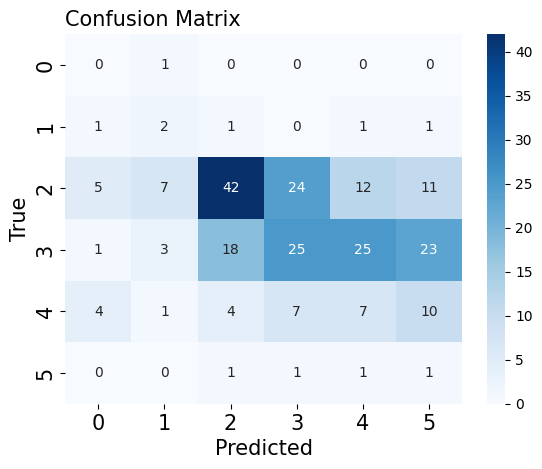

In [69]:
cm = confusion_matrix(actual_labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix', loc='left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Model Building - Neural Network (with a Smaller Learning Rate)

In [70]:
nn_2_model = NN()

In [71]:
optimizer = torch.optim.SGD(nn_2_model.parameters(), lr=0.0001)

In [72]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [73]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = nn_2_model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()

    last_loss = running_loss/ (i+1)
            
    return last_loss

In [74]:
EPOCHS = 1000

avg_loss_list = []
avg_vloss_list = []
acc_list = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    nn_2_model.train()
    avg_loss = train_one_epoch(epoch_number, writer)
    
    nn_2_model.eval()
    running_vloss = 0.0
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        voutputs = nn_2_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / len(valid_loader)
    print('LOSS: training {} validation {}'.format(avg_loss, avg_vloss))
    
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    avg_loss_list.append(avg_loss)
    avg_vloss_list.append(avg_vloss)

    epoch_number += 1

EPOCH 1:
LOSS: training 1.8060739040374756 validation 1.8467344045639038
EPOCH 2:
LOSS: training 1.8058620691299438 validation 1.8464891910552979
EPOCH 3:
LOSS: training 1.8056509494781494 validation 1.8462480306625366
EPOCH 4:
LOSS: training 1.8054417371749878 validation 1.8460078239440918
EPOCH 5:
LOSS: training 1.8052345514297485 validation 1.84577214717865
EPOCH 6:
LOSS: training 1.805029273033142 validation 1.8455380201339722
EPOCH 7:
LOSS: training 1.804826259613037 validation 1.845309853553772
EPOCH 8:
LOSS: training 1.8046250343322754 validation 1.8450855016708374
EPOCH 9:
LOSS: training 1.8044250011444092 validation 1.8448647260665894
EPOCH 10:
LOSS: training 1.804227352142334 validation 1.8446511030197144
EPOCH 11:
LOSS: training 1.804032802581787 validation 1.8444435596466064
EPOCH 12:
LOSS: training 1.8038409948349 validation 1.8442387580871582
EPOCH 13:
LOSS: training 1.8036494255065918 validation 1.844037652015686
EPOCH 14:
LOSS: training 1.8034577369689941 validation 1.8

In [75]:
numpy_array_list = [tensor.detach().numpy() for tensor in avg_vloss_list]

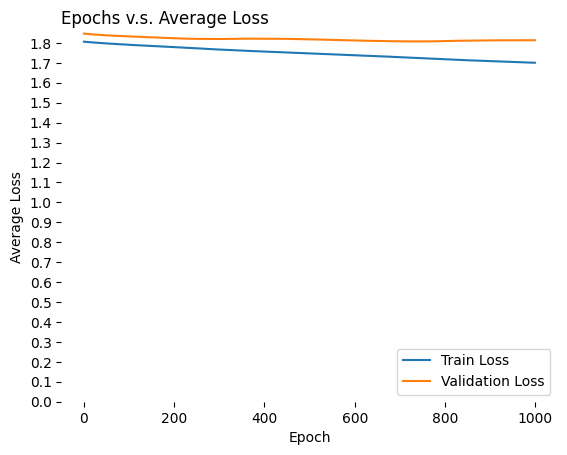

In [76]:
max_value = max(np.max(avg_loss_list), np.max(numpy_array_list))

plt.plot(avg_loss_list)
plt.plot(numpy_array_list)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yticks(np.arange(0, max_value, 0.1))
plt.title('Epochs v.s. Average Loss', loc='left')
plt.legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax = plt.gca()
ax.set_frame_on(False)

## Model Evaluation

In [77]:
nn_2_model.eval()

predicted_classes = []
actual_labels = []


with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        toutputs = nn_2_model(tinputs)
        
        _, predicted = torch.max(toutputs, 1)
        
        predicted_classes.extend(predicted.cpu().numpy())
        actual_labels.extend(tlabels.cpu().numpy())

print("Predicted Classes: ", predicted_classes)
print("Actual Labels: ", actual_labels)

Predicted Classes:  [np.int64(1), np.int64(1), np.int64(4), np.int64(4), np.int64(4), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(5), np.int64(1), np.int64(4), np.int64(4), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(4), np.int64(1), np.int64(4), np.int64(5), np.int64(4), np.int64(5), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(4), np.int64(5), np.int64(0), np.int64(1), np.int64(5), np.int64(1), np.int64(5), np.int64(5), np.int64(5), np.int64(1), np.int64(5), np.int64(1), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(4), np.int64(4), np.int64(1), np.int64(5), np.int64(4), np.int64(1), np.int64(5), np.int64(4), np.int64(5), np.int64(1), np.int64(5), np.int64(1), np.int64(4), np.int64(1), np.int64(4), np.int64(0), np.int64(5), np.i

In [78]:
y_test.head(10)

0    3
1    2
2    3
3    2
4    3
5    2
6    2
7    2
8    2
9    3
Name: quality, dtype: int64

In [79]:
accuracy = accuracy_score(actual_labels,predicted_classes)
f1 = f1_score(actual_labels,predicted_classes, average='weighted')
print(f"\nModel Accuracy: {accuracy:.2f}")
print(f"\nModel F1 Score: {f1:.2f}")


Model Accuracy: 0.08

Model F1 Score: 0.07


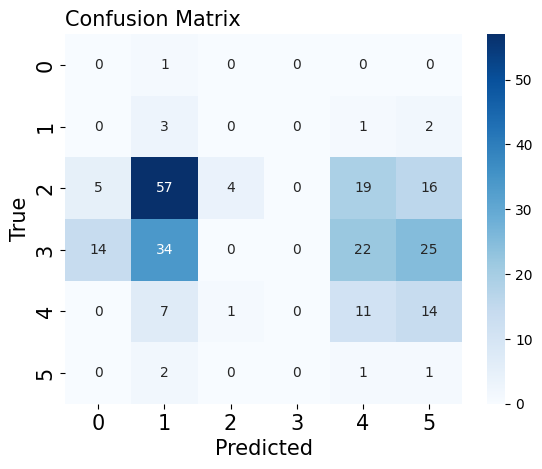

In [80]:
cm = confusion_matrix(actual_labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix', loc='left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()